# Credit Card Fraud Detection 
# Anomaly-Detection-using-the-multivariate-gaussian-distribution

Problem Description: Given a credit card transaction, determine if transaction is Genuine or Fraud.

Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud/home 

ML Challenge: Anamoly Detection, Highly Skewed Dataset
        

## Algorithm Used: multivariate-gaussian-distribution

How Anomaly detection using multivariate-gaussian-distribution works???

## Firstly lets talk about univariate gaussian distribution
In this method, it is assumed that normal data follows gaussian distribution i.e. with  mean(m) and stddev(d). Any point which is outside the scope of this gaussian distribution is an Anomaly.
Hence, the aim is to compute p(x) using mean and stddev and find eps e such that a given data point is anomaly if p(x) < e; otherwise normal.

This method can be extended to multi variate case wherein p(x) is calculated considering the distribution of multiple variables together.

## Steps for anomaly detection using multivariate-gaussian-distribution

1. Using Exploratory analysis, determine important features for anomaly detection. 
    Here we can use mean and stddev of single variable and see how they differ for normal and anamolous case or else inspect distribution of 2 or more variables together and see if they significantly differ from each other for normal and anamolous case. Best suitable method for given dataset can be determined using validation dataset.
    In this case we have inspected only one variable at a time. And removed variables who's distribution is same for both normal and fraud cases

2. Standarize Dataset  

3. Splitting Dataset into train , validation and test set
    Since we need to compute p(x) only using normal variables, we will split dataset such that training set contains only normal data and fraud cases are in validation and test set.
    
4. Using train and val set determine best eps value for predicting value as fraud/normal.    



In [1]:
#imports
import pandas as pd
import math
import numpy as np
import MyUtils as myutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

%matplotlib inline

In [2]:
#Read Dataset
dfAll=pd.read_csv("creditcard.csv")
print(dfAll.columns)
print(dfAll['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
0    284315
1       492
Name: Class, dtype: int64


<u>Observations</u>

1. Dataset is highly skewed with only 0.172 Fraud Transactions
2. Features: V1-V28 are PCA Output; Amount and Time 

This means we will be able to do very limited feature engg.!!

1. To begin with lets explore PCA outputs for both Classes

C:\Users\a669593\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


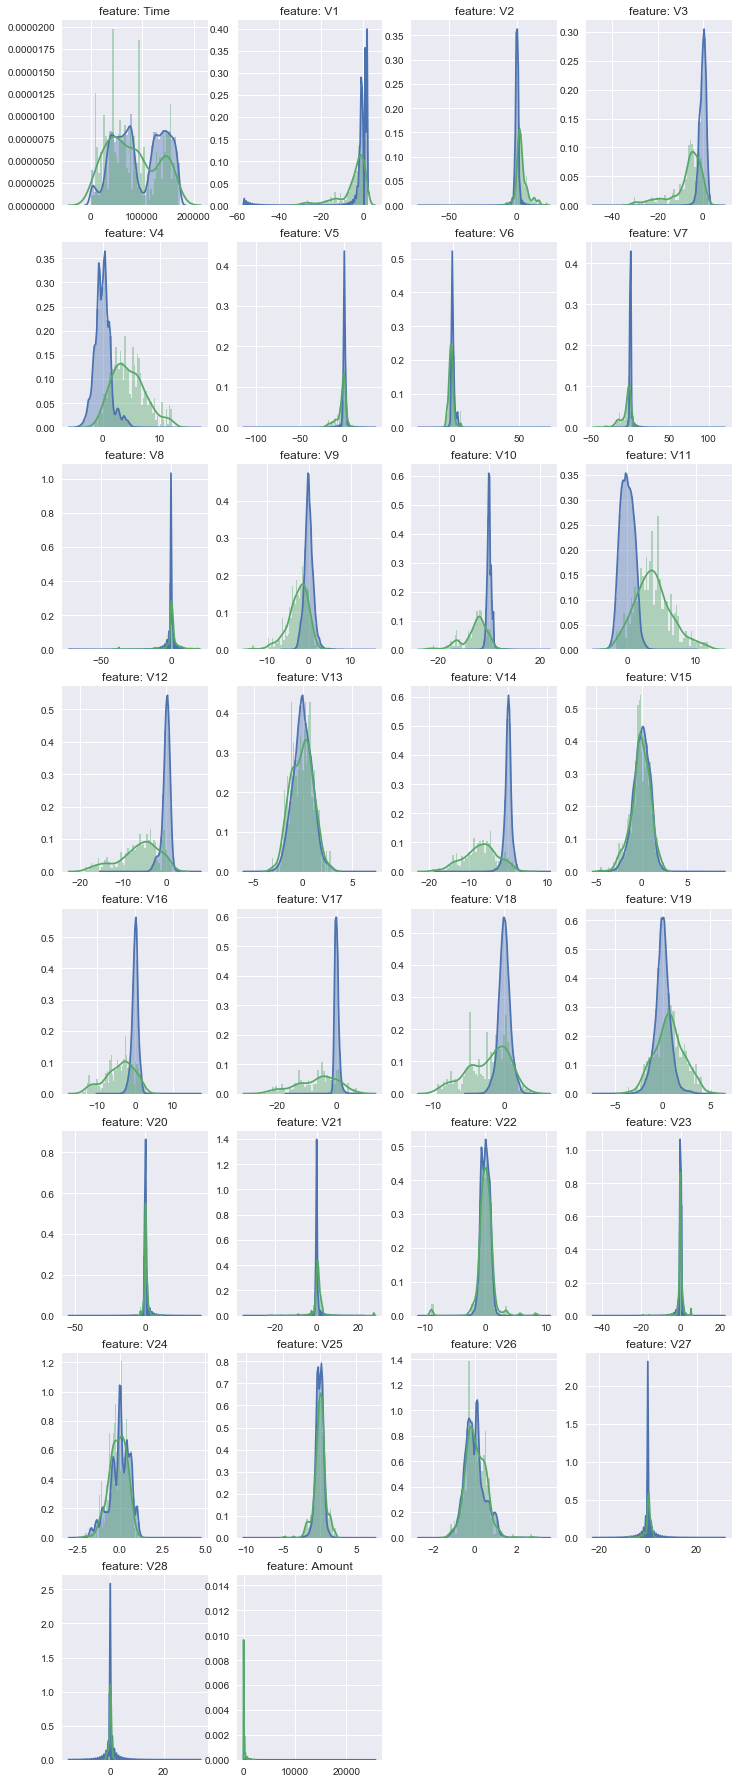

In [3]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(8, 4)
for i, cn in enumerate(dfAll):
    if cn=="Class":
        continue
    ax = plt.subplot(gs[i])
    sns.distplot(dfAll[cn][dfAll['Class']==0], bins=50)
    sns.distplot(dfAll[cn][dfAll['Class']==1], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

The above results show that many of later features are very similar(mean and stddev) for both classes and hence may not contribute much to ml.
Hence removing them.

In [4]:
# this will be dropped in cross validation
dropCols=['V13','V15','V21','V22','V23','V24','V25','V26','V27','V28']



dfAll=dfAll.drop(['Time'],axis=1) #Not useful in this particular analysis


## Lets Define Some necessary Functions

In [5]:
def plotProbs(X_val,y_val,col):
    dfNormal=X_val[y_val==0]
    dfFraud=X_val[y_val==1]
    import seaborn as sns
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(1, 2)
    plt.figure(figsize=(7,5))
    ax = plt.subplot(gs[0])
    ax.set_title(col+' Distribution for normal')
    sns.distplot(dfNormal[col], bins=50)
    ax = plt.subplot(gs[1])
    ax.set_title(col+' Distribution for  fraud')
    sns.distplot(dfFraud[col], bins=50)
    #ax.set_xlabel('')

    plt.show()



def feature_normalize(dataset):
    #mu = np.mean(dataset,axis=0)
    #sigma = np.std(dataset,axis=0)
    mu=np.min(dataset,axis=0)
    sigma=np.max(dataset,axis=0)-np.min(dataset,axis=0)

    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


def getMeanStdProb(df,mu=None,sigma=None):
    if mu is None:
        mu, sigma=estimateGaussian(df)

    df['prob']=multivariateGaussian(df,mu,sigma)
    return df,mu, sigma


def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon,epsilons



def PreprocessDataset(df):
    # Histogram showed V2-V28 are fairly normally distributed. Hence only Amunt and V1 need preprocessing.
    
    df['Amount']=np.log(df['Amount']+1)
    
    df['V1']=df['V1']+100
    df['V1']=df['V1']**0.1
    #sns.distplot(df['V1'], bins=50)
    # Since V1 appears to be bimodal, Another variation to try would be to try to create two models for these two modes of V1.
    """
    df=df+1
    """
    return df

def CalculateResults(Phase,X,yactual,eps,epsilons,grandRes=None,grandRes2=None,muTrain=None,sigmaTrain=None,plotROC=False):
    print()
    print(Phase)
    Pred=X['prob']<eps
    acc_score,rs,f1score,cnf_matrix=myutils.GetScores(yactual,Pred,['Normal','Fraud'])
    cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    print(cm)
    print(cm[1,1],cm[0,0])
    print("eps : "+str(eps))
    #print(acc_score)
    print(f1score)
    print(cnf_matrix)

    #Accuracy approx Precision of Normal class bcoz of heavily imbalanced dataset 
    if grandRes is not None:
        grandRes.append((Phase,crossVal,eps,round(acc_score,2),round(cm[1,1],4),round(cm[0,0],4),muTrain.copy(),sigmaTrain.copy(),epsilons))
        grandRes2.append((cnf_matrix,f1score))
    if plotROC:
        myutils.PlotRecallCurve(yactual,Pred)

## Split Data into Train and Test Set

In [6]:
outputVarName='Class'
crossVal=0
X_trainVal, X_test, y_trainVal, y_test = myutils.GetTrainTest(dfAll,outputVarName)

print(y_trainVal.value_counts())
print(y_test.value_counts())

0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


## Split Data into Train and Val Set

0    181960
1       315
Name: Class, dtype: int64
0    45491
1       79
Name: Class, dtype: int64


C:\Users\a669593\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a669593\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\a669593\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

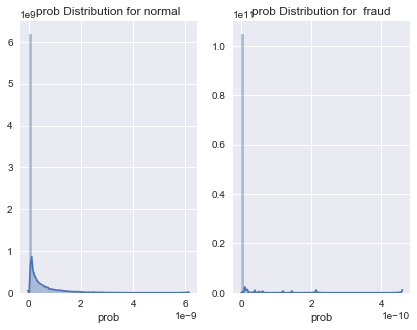

C:\Users\a669593\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



------Val-----ColDrop : NO
[[0.50838627 0.49161373]
 [0.03553299 0.96446701]]
0.9644670050761421 0.5083862742080851
eps : 6.11568541697959e-12
             precision    recall  f1-score   support

     Normal       1.00      0.51      0.67     45491
      Fraud       0.02      0.96      0.03       394

avg / total       0.99      0.51      0.67     45885

[[23127 22364]
 [   14   380]]


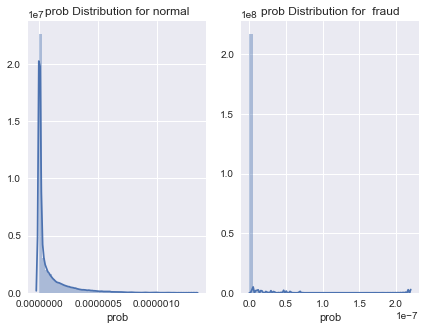


------Val-----ColDrop : YES
[[0.68085995 0.31914005]
 [0.05329949 0.94670051]]
0.9467005076142132 0.6808599503198435
eps : 1.3209882853998547e-09
             precision    recall  f1-score   support

     Normal       1.00      0.68      0.81     45491
      Fraud       0.03      0.95      0.05       394

avg / total       0.99      0.68      0.80     45885

[[30973 14518]
 [   21   373]]
0    181961
1       315
Name: Class, dtype: int64
0    45490
1       79
Name: Class, dtype: int64


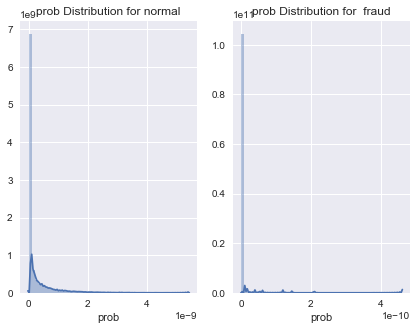


------Val-----ColDrop : NO
[[0.51534403 0.48465597]
 [0.03807107 0.96192893]]
0.9619289340101523 0.5153440316553088
eps : 5.419691689394528e-12
             precision    recall  f1-score   support

     Normal       1.00      0.52      0.68     45490
      Fraud       0.02      0.96      0.03       394

avg / total       0.99      0.52      0.67     45884

[[23443 22047]
 [   15   379]]


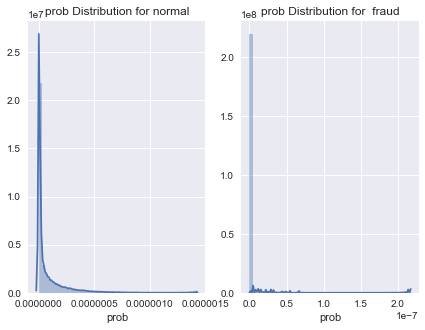


------Val-----ColDrop : YES
[[0.67373049 0.32626951]
 [0.05329949 0.94670051]]
0.9467005076142132 0.6737304902176302
eps : 1.4079499857616744e-09
             precision    recall  f1-score   support

     Normal       1.00      0.67      0.80     45490
      Fraud       0.02      0.95      0.05       394

avg / total       0.99      0.68      0.80     45884

[[30648 14842]
 [   21   373]]
0    181961
1       315
Name: Class, dtype: int64
0    45490
1       79
Name: Class, dtype: int64


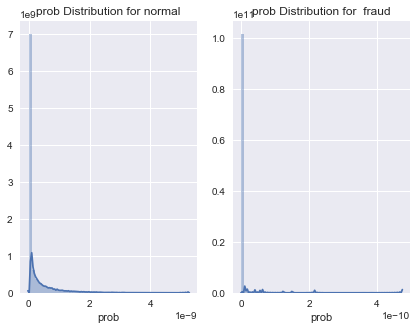


------Val-----ColDrop : NO
[[0.52530226 0.47469774]
 [0.03807107 0.96192893]]
0.9619289340101523 0.5253022642338976
eps : 5.2529756241715794e-12
             precision    recall  f1-score   support

     Normal       1.00      0.53      0.69     45490
      Fraud       0.02      0.96      0.03       394

avg / total       0.99      0.53      0.68     45884

[[23896 21594]
 [   15   379]]


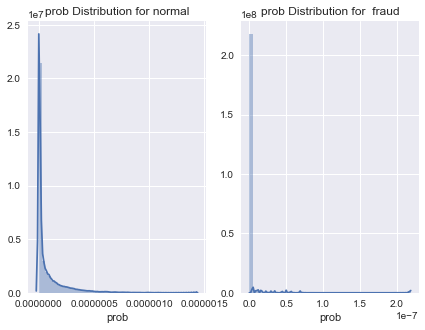


------Val-----ColDrop : YES
[[0.68054517 0.31945483]
 [0.05329949 0.94670051]]
0.9467005076142132 0.6805451747636844
eps : 1.4142288067990921e-09
             precision    recall  f1-score   support

     Normal       1.00      0.68      0.81     45490
      Fraud       0.03      0.95      0.05       394

avg / total       0.99      0.68      0.80     45884

[[30958 14532]
 [   21   373]]
0    181961
1       315
Name: Class, dtype: int64
0    45490
1       79
Name: Class, dtype: int64


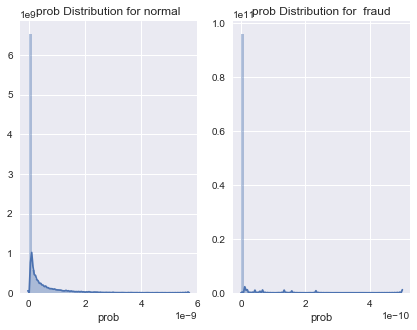


------Val-----ColDrop : NO
[[0.52517037 0.47482963]
 [0.03807107 0.96192893]]
0.9619289340101523 0.5251703671136514
eps : 5.663297151865397e-12
             precision    recall  f1-score   support

     Normal       1.00      0.53      0.69     45490
      Fraud       0.02      0.96      0.03       394

avg / total       0.99      0.53      0.68     45884

[[23890 21600]
 [   15   379]]


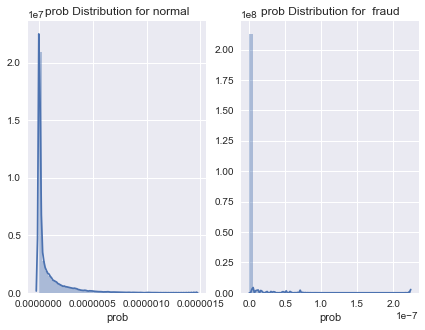


------Val-----ColDrop : YES
[[0.67764344 0.32235656]
 [0.05329949 0.94670051]]
0.9467005076142132 0.6776434381182678
eps : 1.4506460046389394e-09
             precision    recall  f1-score   support

     Normal       1.00      0.68      0.81     45490
      Fraud       0.02      0.95      0.05       394

avg / total       0.99      0.68      0.80     45884

[[30826 14664]
 [   21   373]]
0    181961
1       316
Name: Class, dtype: int64
0    45490
1       78
Name: Class, dtype: int64


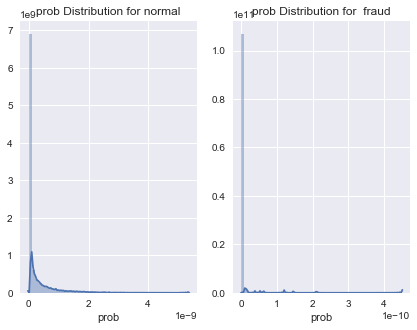


------Val-----ColDrop : NO
[[0.52257639 0.47742361]
 [0.03807107 0.96192893]]
0.9619289340101523 0.5225763904154759
eps : 5.3454152995446e-12
             precision    recall  f1-score   support

     Normal       1.00      0.52      0.69     45490
      Fraud       0.02      0.96      0.03       394

avg / total       0.99      0.53      0.68     45884

[[23772 21718]
 [   15   379]]


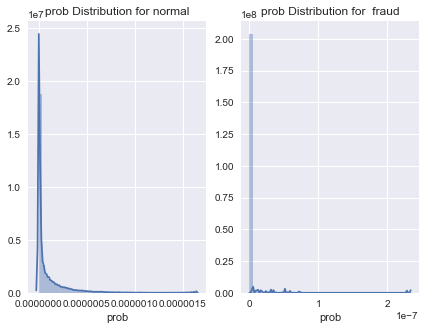


------Val-----ColDrop : YES
[[0.67322488 0.32677512]
 [0.05329949 0.94670051]]
0.9467005076142132 0.6732248845900198
eps : 1.6313831090672209e-09
             precision    recall  f1-score   support

     Normal       1.00      0.67      0.80     45490
      Fraud       0.02      0.95      0.05       394

avg / total       0.99      0.68      0.80     45884

[[30625 14865]
 [   21   373]]


In [7]:
grandRes=[]
grandRes2=[]

for X_train, X_val,y_train, y_val in myutils.GetkFoldedTrainVal(X_trainVal,y_trainVal):
    crossVal+=1
    print(y_train.value_counts())
    print(y_val.value_counts())

    #for anamoly detection prepare train dataset only on  only normal values
    X_val=X_val.append(X_train[y_train==1])
    y_val=y_val.append(y_train[y_train==1])
    X_train=X_train[y_train==0]
    y_train=y_train[y_train==0]

    #Now Training has only postive examples as desired for Gaussian Based ANAMOLY DETECTION

    X_train=PreprocessDataset(X_train)
    X_val=PreprocessDataset(X_val)

    for i in range(0,2):
        sdrop="NO"
        
        if i==1:
            X_train=X_train.drop(dropCols,axis=1)
            X_val=X_val.drop(dropCols,axis=1)
            sdrop="YES"
        
        #print(X_train.info())
        #print(X_train.describe())
        X_trainProc,muTrain,sigmaTrain=getMeanStdProb(X_train.copy())
        X_valProc,dfpxVal,_=getMeanStdProb(X_val.copy(),muTrain,sigmaTrain)

        """
        plt.figure(figsize=(12,4))
        sns.distplot(X_train['prob'], bins=5)
        sns.distplot(X_val['prob'], bins=5)
        plt.show()
        """

        #myutils.fnPlotCols(X_train,colNames=['prob'],num_bins=100)
        X_trainProc['prob'].describe()
        X_valProc['prob'].describe()
        eps=np.max(X_trainProc['prob'])


        plotProbs(X_valProc,y_val,'prob')
        fscore, ep,epsilons = selectThresholdByCV(X_valProc['prob'],y_val)
        CalculateResults("------Val-----"+"ColDrop : "+sdrop,X_valProc,y_val,ep,epsilons,grandRes,grandRes2,muTrain.copy(),sigmaTrain.copy())

In [8]:
dfRes=pd.DataFrame(grandRes,columns=['Phase','CVNum','EPS','PrecNormal','FRecall','NRecall','muTrain','sigTrain','epsilons'])

In [9]:
dfRes.sort_values(['FRecall', 'PrecNormal'], ascending=[False, False])

,Phase,CVNum,EPS,PrecNormal,FRecall,NRecall,muTrain,sigTrain,epsilons
0,------Val-----ColDrop : NO,1,6.11568541697959e-12,0.51,0.9645,0.5084,V1 1.584879 V2 -0.007532 V3 ...,"[[1.0019050518522295e-05, 0.000233726799878549...","[0.0, 6.11568541697959e-12, 1.223137083395918e..."
4,------Val-----ColDrop : NO,3,5.2529756241715794e-12,0.53,0.9619,0.5253,V1 1.584878 V2 -0.004249 V3 ...,"[[9.935682132969595e-06, 0.0002330223675637241...","[0.0, 5.2529756241715794e-12, 1.05059512483431..."
6,------Val-----ColDrop : NO,4,5.663297151865397e-12,0.53,0.9619,0.5252,V1 1.584875 V2 -0.007346 V3 ...,"[[9.938293383610605e-06, 0.0002381897731200452...","[0.0, 5.663297151865397e-12, 1.132659430373079..."
8,------Val-----ColDrop : NO,5,5.3454152995446e-12,0.53,0.9619,0.5226,V1 1.584873 V2 -0.008050 V3 ...,"[[1.0119192687902109e-05, 0.000352452831916772...","[0.0, 5.3454152995446e-12, 1.06908305990892e-1..."
2,------Val-----ColDrop : NO,2,5.419691689394528e-12,0.52,0.9619,0.5153,V1 1.584878 V2 -0.005262 V3 ...,"[[9.945623027177924e-06, 0.0002270076435062073...","[0.0, 5.419691689394528e-12, 1.083938337878905..."
1,------Val-----ColDrop : YES,1,1.3209882853998547e-09,0.68,0.9467,0.6809,V1 1.584879 V2 -0.007532 V3 ...,"[[1.0019050518522295e-05, 0.000233726799878549...","[0.0, 1.3209882853998547e-09, 2.64197657079970..."
3,------Val-----ColDrop : YES,2,1.4079499857616744e-09,0.68,0.9467,0.6737,V1 1.584878 V2 -0.005262 V3 ...,"[[9.945623027177924e-06, 0.0002270076435062073...","[0.0, 1.4079499857616744e-09, 2.81589997152334..."
5,------Val-----ColDrop : YES,3,1.4142288067990921e-09,0.68,0.9467,0.6805,V1 1.584878 V2 -0.004249 V3 ...,"[[9.935682132969595e-06, 0.0002330223675637241...","[0.0, 1.4142288067990921e-09, 2.82845761359818..."
7,------Val-----ColDrop : YES,4,1.4506460046389394e-09,0.68,0.9467,0.6776,V1 1.584875 V2 -0.007346 V3 ...,"[[9.938293383610605e-06, 0.0002381897731200452...","[0.0, 1.4506460046389394e-09, 2.90129200927787..."
9,------Val-----ColDrop : YES,5,1.6313831090672209e-09,0.68,0.9467,0.6732,V1 1.584873 V2 -0.008050 V3 ...,"[[1.0119192687902109e-05, 0.000352452831916772...","[0.0, 1.6313831090672209e-09, 3.26276621813444..."


##Observations

So we see that dropping columns increases precision but decreases recall.

We can choose best mu depending upon tradeoff between Precision and Recall.

As this is fraud detection we will choose eps which gives maximum Fraud Recall with best possible precision which in this case is index 0

In [10]:


bestIndex=0
bestMu,bestSigma,eps=dfRes['muTrain'][bestIndex],dfRes['sigTrain'][bestIndex],dfRes['EPS'][bestIndex]

print(eps)
print(len(bestMu))


6.11568541697959e-12
29


In [11]:
X_testPro=PreprocessDataset(X_test.copy())
X_testPro,dfpxTest,_=getMeanStdProb(X_testPro,bestMu,bestSigma)
#for eps in [1.4807699013771287e-17]:
#for eps in epsilons:	
		#CalculateResults("------Train-----",X_train,y_train,eps)
CalculateResults("------Test-----",X_testPro,y_test,eps,True)


------Test-----
[[0.51218697 0.48781303]
 [0.         1.        ]]
1.0 0.5121869724254361
eps : 6.11568541697959e-12
             precision    recall  f1-score   support

     Normal       1.00      0.51      0.68     56864
      Fraud       0.00      1.00      0.01        98

avg / total       1.00      0.51      0.68     56962

[[29125 27739]
 [    0    98]]


Thus first iteration gives us good recall but too many false positives, we need to use better algorithms and other preprocessing techniques to improve output.